In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [3]:
## Parameters

# task_type='Iris_classification'
task_type='Regression'
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

Nin: int = 2
Ninter: int = 2
Nout: int = 3

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.2  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

# R_update: str = 'propto'
R_update: str = 'deltaR'
R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1, 0.85, 1.05, 1., 2.95, 0.55])

# training length
iterations = 820  # number of sampled of p

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
# access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         Ninter)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

alpha_vec [0.2 0.2 0.2]
input M mismatches output and input


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, inter_nodes_arr, output_nodes_arr, ground_nodes_arr = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.Ninter, Variabs.Nout)

In [6]:
print('input_nodes_arr ', input_nodes_arr)
print('inter_nodes_arr ', inter_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1]
inter_nodes_arr  [2 3]
output_nodes_arr  [4 5 6]
ground_nodes_arr  [7]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           inter_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs.Nin, Variabs.Nout, Ninter)
else:
    State = Network_State(Variabs.Nin, Variabs.Nout)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
else:
    State.initiate_resistances(BigClass)
BigClass.add_State(State)  # add to big class

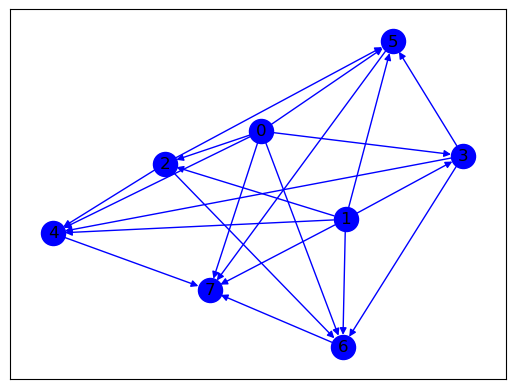

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    # print('i', i)
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % 15 == 0 and task_type == 'Iris_classification':
        targets_mat = zeros([3, 3])
        for j in range(3):
            State.draw_p_means_Iris(Variabs, j)
            # print('means[j]', State.input_drawn)
            State.solve_flow_given_problem(BigClass, "measure_for_mean")  # measure and don't change resistances
            # print('targets[j]', State.output)
            targets_mat[j] = State.output
        State.assign_targets_Iris(targets_mat)
        print(targets_mat)
    State.draw_p_in_and_desired(Variabs, i)
    #print('p_drawn ', State.input_drawn)
    # print('desired output', State.desired)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    # print('output meausred', State.output)
    if not i % 2:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_input_dual(BigClass)
        State.update_output_dual(BigClass)
        if access_interNodes:
            State.update_inter_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)

input_drawn [0.06265907 0.5294423 ]
desired output= [0.11528732 0.068609   0.16008587]
len nodes_tuple 2
output measured= [0.21814261 0.21814261 0.21814261]
input_drawn [1.32123568 0.9721268 ]
desired output= [0.39261071 0.4275216  0.31806275]
len nodes_tuple 2
output measured= [0.84492302 0.84492302 0.84492302]
loss= [[-0.45231231 -0.41740142 -0.52686027]
 [-0.10285529 -0.14953361 -0.05805674]]
time= 1
input_dual_nxt= [0.27339515 0.09616244]
output_dual_nxt [-0.04380656 -0.03357886 -0.05876737]
inter_dual_nxt= [0.15560319 0.15560319]
len nodes_tuple 4
input_drawn [0.25069117 1.81302616]
desired output= [0.40020891 0.24397541 0.54892167]
len nodes_tuple 2
output measured= [0.75712815 0.76077084 0.75173112]
input_drawn [1.03507378 1.54100377]
desired output= [0.46346182 0.41286882 0.48300261]
len nodes_tuple 2
output measured= [0.90681335 0.91101987 0.90057087]
loss= [[-0.44335153 -0.49815105 -0.41756826]
 [-0.35691924 -0.51679543 -0.20280945]]
time= 2
input_dual_nxt= [ 0.04432495 -0.01

input_drawn [1.86312035 1.72173013]
desired output= [0.62381408 0.6379531  0.55378145]
len nodes_tuple 2
output measured= [0.69278818 0.65432844 0.70590871]
input_drawn [1.82715634 0.44214454]
desired output= [0.36250236 0.50100354 0.16918649]
len nodes_tuple 2
output measured= [0.41228952 0.3895443  0.42004209]
loss= [[-0.04978716  0.11145924 -0.2508556 ]
 [-0.0689741  -0.01637534 -0.15212726]]
time= 61
input_dual_nxt= [0.00034736 0.01235905]
output_dual_nxt [-0.00107638 -0.00676971  0.00564463]
inter_dual_nxt= [0.00539353 0.00539353]
len nodes_tuple 4
input_drawn [0.52593055 1.54217373]
desired output= [0.38732433 0.28570001 0.47317073]
len nodes_tuple 2
output measured= [0.42033012 0.39416596 0.43124146]
input_drawn [0.28614196 1.72671063]
desired output= [0.38826342 0.24420655 0.52373603]
len nodes_tuple 2
output measured= [0.41797931 0.39191126 0.42885412]
loss= [[-0.02971589 -0.1477047   0.09488191]
 [-0.03300579 -0.10846595  0.04192927]]
time= 62
input_dual_nxt= [ 0.00081546 -0.

input_drawn [1.93661431 0.25915941]
desired output= [0.34232403 0.51006952 0.11648011]
len nodes_tuple 2
output measured= [0.34116554 0.31285013 0.35026585]
input_drawn [1.02194745 0.39032699]
desired output= [0.23135752 0.29451956 0.13753705]
len nodes_tuple 2
output measured= [0.23202637 0.21267953 0.23825026]
loss= [[-0.00066886  0.08184004 -0.10071322]
 [ 0.00115849  0.19721939 -0.23378574]]
time= 135
input_dual_nxt= [ 0.00290239 -0.00041622]
output_dual_nxt [ 3.98869818e-05  2.31152390e-03 -2.98123950e-03]
inter_dual_nxt= [0.0006376 0.0006376]
len nodes_tuple 4
input_drawn [1.30864355 1.54550539]
desired output= [0.50539761 0.48171143 0.48982449]
len nodes_tuple 2
output measured= [0.51152037 0.47001484 0.52362157]
input_drawn [1.95850519 0.78829993]
desired output= [0.45143576 0.56845629 0.27566008]
len nodes_tuple 2
output measured= [0.45275059 0.41625032 0.46337917]
loss= [[-0.00131483  0.15220597 -0.18771909]
 [-0.00612276  0.01169659 -0.03379708]]
time= 136
input_dual_nxt= [ 

loss= [[ 0.00013764  0.02412578 -0.03023119]
 [-0.00227147 -0.01175428  0.00565274]]
time= 205
input_dual_nxt= [0.00010348 0.00033262]
output_dual_nxt [-8.33379667e-05 -1.13955958e-03  1.26205269e-03]
inter_dual_nxt= [0.00018188 0.00018188]
len nodes_tuple 4
input_drawn [0.85882986 1.45411769]
desired output= [0.41964802 0.36011923 0.4534119 ]
len nodes_tuple 2
output measured= [0.42242212 0.3873713  0.43010227]
input_drawn [0.7625918  1.66104466]
desired output= [0.4465977  0.35675242 0.51356523]
len nodes_tuple 2
output measured= [0.4509662  0.41349908 0.45917772]
loss= [[-0.0043685  -0.05674667  0.05438752]
 [-0.0027741  -0.02725207  0.02330964]]
time= 206
input_dual_nxt= [-2.13789364e-07  4.59680807e-07]
output_dual_nxt [-9.10209896e-06 -1.54125664e-04  1.80720678e-04]
inter_dual_nxt= [1.52541894e-07 1.52541894e-07]
len nodes_tuple 4
input_drawn [1.87899416 0.41330738]
desired output= [0.3645106  0.51107928 0.1615721 ]
len nodes_tuple 2
output measured= [0.35631753 0.32704537 0.362

input_drawn [0.89784568 0.01297456]
desired output= [0.13727176 0.22575888 0.02184928]
len nodes_tuple 2
output measured= [0.13216208 0.11982643 0.13623972]
input_drawn [0.03691075 0.81059035]
desired output= [0.16765468 0.09028672 0.24391532]
len nodes_tuple 2
output measured= [0.17130449 0.15492587 0.17674938]
loss= [[-0.00364981 -0.06463915  0.06716594]
 [ 0.00510969  0.10593244 -0.11439044]]
time= 220
input_dual_nxt= [ 0.00038317 -0.00035499]
output_dual_nxt [-6.85735356e-05 -1.19739334e-03  1.47095732e-03]
inter_dual_nxt= [-5.74104694e-05 -5.74104694e-05]
len nodes_tuple 4
input_drawn [1.53721542 0.27937865]
desired output= [0.28645804 0.41224172 0.1145579 ]
len nodes_tuple 2
output measured= [0.27888601 0.25233455 0.28802069]
input_drawn [0.60361842 0.86180435]
desired output= [0.26290363 0.23708504 0.27061367]
len nodes_tuple 2
output measured= [0.26352445 0.23813818 0.27228328]
loss= [[-0.00062082 -0.00105314 -0.00166961]
 [ 0.00757203  0.15990717 -0.17346279]]
time= 221
input_

output measured= [0.10217002 0.09402099 0.10328722]
input_drawn [0.85145911 0.12981807]
desired output= [0.15368248 0.22584658 0.0559746 ]
len nodes_tuple 2
output measured= [0.14889301 0.13702302 0.15052022]
loss= [[ 0.00478946  0.08882356 -0.09454561]
 [ 0.00316201  0.05865783 -0.06244703]]
time= 280
input_dual_nxt= [1.70993109e-05 1.94132465e-06]
output_dual_nxt [ 1.52079162e-05  2.59437594e-04 -3.03222459e-04]
inter_dual_nxt= [5.60917667e-06 5.60917667e-06]
len nodes_tuple 4
input_drawn [0.56998223 0.21729468]
desired output= [0.12895627 0.16422503 0.07658805]
len nodes_tuple 2
output measured= [0.12638235 0.11629921 0.12772496]
input_drawn [0.44949214 0.35294847]
desired output= [0.13801351 0.14766788 0.11487438]
len nodes_tuple 2
output measured= [0.13686227 0.12589234 0.13832408]
loss= [[ 0.00115124  0.02177554 -0.02344969]
 [ 0.00257392  0.04792581 -0.05113691]]
time= 281
input_dual_nxt= [ 2.75370493e-06 -3.10025909e-06]
output_dual_nxt [-2.98190253e-06 -5.01725970e-05  5.86920

output measured= [0.65513377 0.58540763 0.68157705]
loss= [[ 0.00500968  0.0896345  -0.09547008]
 [-0.00072212 -0.01308744  0.01365742]]
time= 355
input_dual_nxt= [0.00022845 0.00016936]
output_dual_nxt [ 0.0005731   0.00917918 -0.01135092]
inter_dual_nxt= [0.00014112 0.00014112]
len nodes_tuple 4
input_drawn [0.39993299 1.88852875]
desired output= [0.4376957  0.28883612 0.57455728]
len nodes_tuple 2
output measured= [0.44392264 0.40125296 0.45595804]
input_drawn [0.48443386 0.18121164]
desired output= [0.10890741 0.13922963 0.06405217]
len nodes_tuple 2
output measured= [0.10651909 0.09641639 0.10936003]
loss= [[ 0.00238832  0.04281324 -0.04530786]
 [-0.00622695 -0.11241683  0.11859925]]
time= 356
input_dual_nxt= [ 1.04411832e-06 -2.10961271e-05]
output_dual_nxt [-0.00058136 -0.00946396  0.01136198]
inter_dual_nxt= [-9.46070255e-06 -9.46070255e-06]
len nodes_tuple 4
input_drawn [1.75871138 0.7998401 ]
desired output= [0.42377473 0.51966185 0.27512626]
len nodes_tuple 2
output measured

input_drawn [1.75804096 1.01984414]
desired output= [0.46767497 0.54149465 0.34111406]
len nodes_tuple 2
output measured= [0.46018006 0.40752386 0.48304267]
input_drawn [0.50076015 1.23986934]
desired output= [0.32308789 0.24917697 0.381976  ]
len nodes_tuple 2
output measured= [0.32521744 0.28770352 0.34154706]
loss= [[-0.00212955 -0.03852655  0.04042895]
 [ 0.00749491  0.1339708  -0.14192861]]
time= 370
input_dual_nxt= [ 5.92796794e-05 -1.03739939e-05]
output_dual_nxt [ 0.00025979  0.00413374 -0.00516056]
inter_dual_nxt= [1.15157692e-05 1.15157692e-05]
len nodes_tuple 4
input_drawn [1.64725424 1.17486641]
desired output= [0.48206142 0.5293002  0.38540501]
len nodes_tuple 2
output measured= [0.47616246 0.42400153 0.49696889]
input_drawn [0.75153542 1.57422124]
desired output= [0.42757456 0.34530598 0.48729708]
len nodes_tuple 2
output measured= [0.42961238 0.38226303 0.44853322]
loss= [[-0.00203782 -0.03695705  0.03876386]
 [ 0.00589896  0.10529867 -0.11156388]]
time= 371
input_dual_n

## Plots

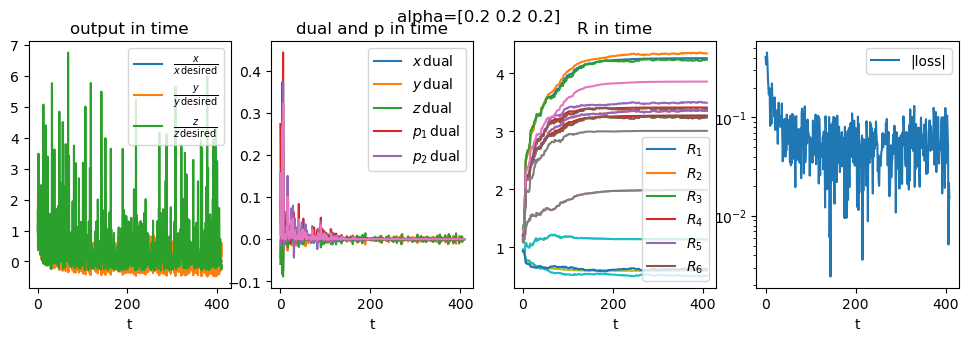

In [12]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M)
else:
        plot_functions.plot_importants(State, Variabs, State.desired_in_t)

## Statistics

### Error

In [13]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.17885202037163475


### Accuracy

In [14]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [0.06265907 0.5294423 ]
desired output= [0.11528732 0.068609   0.16008587]
len nodes_tuple 2
output measured= [0.11735585 0.1056029  0.12094776]


AttributeError: 'Network_State' object has no attribute 'target_mat'

In [ ]:
State.input_drawn = array([1.80555556, 1.875,      2.20338983, 2.5       ])
State.desired = array([0.24273429, 0.36087462, 0.13620468])
State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
State.output

In [ ]:
Variabs.targets

In [ ]:
np.mean(accuracy)

## Checks

In [ ]:
np.linalg.norm(array([0.43308893, 0.28068842]) - array([0.40696115, 0.30632471]))

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)

In [15]:
State.inter_dual_in_t

[array([0.74055137, 0.20364521]),
 array([0.15560319, 0.15560319]),
 array([0.0099707, 0.0099707]),
 array([0.02674695, 0.02674695]),
 array([0.0009046, 0.0009046]),
 array([0.26504718, 0.26504718]),
 array([0.13608801, 0.13608801]),
 array([0.3215186, 0.3215186]),
 array([0.0090069, 0.0090069]),
 array([0.01159387, 0.01159387]),
 array([-0.00052494, -0.00052494]),
 array([0.00940305, 0.00940305]),
 array([0.00216644, 0.00216644]),
 array([1.46528114e-05, 1.46528114e-05]),
 array([0.00186788, 0.00186788]),
 array([0.03013659, 0.03013659]),
 array([0.02400073, 0.02400073]),
 array([0.10199389, 0.10199389]),
 array([0.03768529, 0.03768529]),
 array([0.00901293, 0.00901293]),
 array([0.00040368, 0.00040368]),
 array([0.0064309, 0.0064309]),
 array([0.01751844, 0.01751844]),
 array([0.01112465, 0.01112465]),
 array([0.00343113, 0.00343113]),
 array([0.04572019, 0.04572019]),
 array([0.03713395, 0.03713395]),
 array([0.0033384, 0.0033384]),
 array([0.01432077, 0.01432077]),
 array([0.049505

In [16]:
State.inter_in_t

[array([0.24930584, 0.24930584]),
 array([0.96562631, 0.96562631]),
 array([0.90708002, 0.90708002]),
 array([1.08352342, 1.08352342]),
 array([0.61752902, 0.61752902]),
 array([0.94644042, 0.94644042]),
 array([0.81433813, 0.81433813]),
 array([0.92211316, 0.92211316]),
 array([0.58932558, 0.58932558]),
 array([1.61288267, 1.61288267]),
 array([0.66684774, 0.66684774]),
 array([1.49869701, 1.49869701]),
 array([0.20379907, 0.20379907]),
 array([1.5270711, 1.5270711]),
 array([1.10475323, 1.10475323]),
 array([0.85819241, 0.85819241]),
 array([0.85859694, 0.85859694]),
 array([0.62401692, 0.62401692]),
 array([0.81475803, 0.81475803]),
 array([0.92516484, 0.92516484]),
 array([0.88413393, 0.88413393]),
 array([1.11401215, 1.11401215]),
 array([0.3469879, 0.3469879]),
 array([0.46136582, 0.46136582]),
 array([0.80621361, 0.80621361]),
 array([0.91500196, 0.91500196]),
 array([0.51741053, 0.51741053]),
 array([0.4157675, 0.4157675]),
 array([0.61899579, 0.61899579]),
 array([0.14574386, 

In [ ]:
np.shape(Variabs.M)

In [ ]:
np.shape(Variabs.dataset)

In [ ]:
np.matmul(Variabs.dataset, Variabs.M.T)[0]